In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore, ttest_ind, linregress
from sklearn.cluster import KMeans
import hvplot.pandas

In [2]:
df = pd.read_csv("./marketing_AB.csv")
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


## Summary Statistics

In [3]:
# set Unnamed: 0 as index
df = df.set_index('Unnamed: 0')
df.index.name = None
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [4]:
# show types and count
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


In [5]:
# show summary statisitics
df.describe()

,user id,total ads,most ads hour
count,5.881010e+05,588101.000000,588101.000000
mean,1.310692e+06,24.820876,14.469061
std,2.022260e+05,43.715181,4.834634
min,9.000000e+05,1.000000,0.000000
25%,1.143190e+06,4.000000,11.000000
50%,1.313725e+06,13.000000,14.000000
75%,1.484088e+06,27.000000,18.000000
max,1.654483e+06,2065.000000,23.000000


In [6]:
# what percentage of the population during hr 3 were shown ads?
ad_count = len(df.loc[df["test group"] == "ad"])
psa_count = len(df.loc[df["test group"] == "psa"])

print( "# Ad group:", ad_count)
print( "# PSA group:", psa_count)
print( "% Control:", format(psa_count/ad_count, ".2%"))

# Ad group: 564577
# PSA group: 23524
% Control: 4.17%


In [7]:
# update Most Ads Day to show the number val of the day
mapping_days = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}
df = df.replace({'most ads day': mapping_days})
df.head(5)

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,1,20
1,1119715,ad,False,93,2,22
2,1144181,ad,False,21,2,18
3,1435133,ad,False,355,2,10
4,1015700,ad,False,276,5,14


array([[<Axes: title={'center': 'total ads'}>,
        <Axes: title={'center': 'most ads day'}>],
       [<Axes: title={'center': 'most ads hour'}>, <Axes: >]],
      dtype=object)

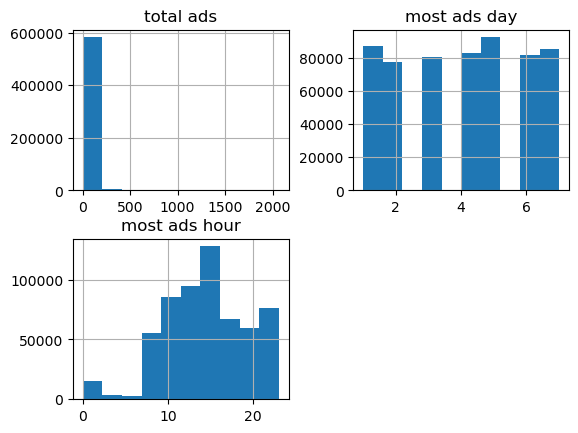

In [8]:
# histogram of ad columns
df[["total ads", "most ads day", "most ads hour"]].hist()

## Remove Outliers
Some users were shown way too many ads

In [9]:
z_tot = np.abs(zscore(df['total ads']))
df = df[z_tot < 3]
df.describe()

,user id,total ads,most ads day,most ads hour
count,5.780700e+05,578070.000000,578070.000000,578070.000000
mean,1.310317e+06,20.684580,4.026405,14.475188
std,2.022017e+05,24.889421,2.004488,4.836649
min,9.000000e+05,1.000000,1.000000,0.000000
25%,1.142685e+06,4.000000,2.000000,11.000000
50%,1.313058e+06,13.000000,4.000000,14.000000
75%,1.483636e+06,26.000000,6.000000,18.000000
max,1.654483e+06,155.000000,7.000000,23.000000


In [10]:
df = pd.DataFrame(df.loc[df['total ads'] < 200,:])
len(df)

578070

array([[<Axes: title={'center': 'total ads'}>,
        <Axes: title={'center': 'most ads day'}>],
       [<Axes: title={'center': 'most ads hour'}>, <Axes: >]],
      dtype=object)

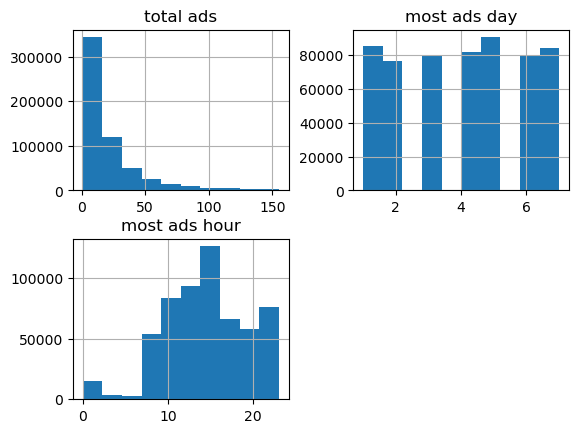

In [11]:
# histogram of ad columns
df[["total ads", "most ads day", "most ads hour"]].hist()

## Conversions by Group
Get the lift/loss of serving ads to the experiment population

In [12]:
# show number of conversions by test group
df_bar = df.groupby(["test group", "converted"]).size()
df_bar.head()

test group  converted
ad          False        542116
            True          12882
psa         False         22714
            True            358
dtype: int64

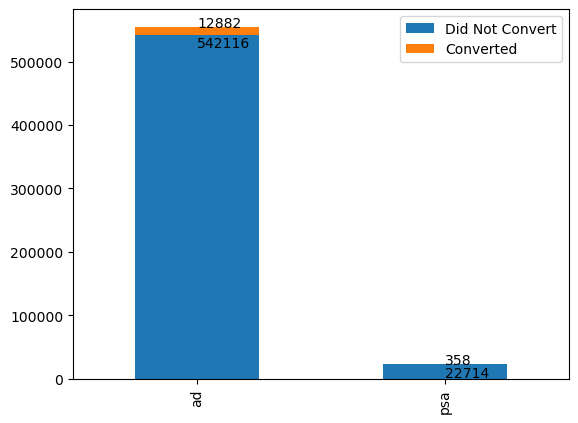

In [13]:
# plot experiement buckets
df_bar_pivot = pd.DataFrame({
    'Did Not Convert': [df_bar.iloc[0], df_bar.iloc[2]],
    'Converted': [df_bar.iloc[1], df_bar.iloc[3]]
}, index = ["ad", "psa"])
ax = df_bar_pivot.plot.bar(stacked=True)

y_offset = 20_000

# Did not convert Labels
ax.text(0,
       df_bar_pivot["Did Not Convert"]["ad"] - y_offset,
       df_bar_pivot["Did Not Convert"]["ad"])

ax.text(1,
       df_bar_pivot["Did Not Convert"]["psa"] - y_offset,
       df_bar_pivot["Did Not Convert"]["psa"])

# Converted Labels
ax.text(0,
       df_bar_pivot["Converted"]["ad"] + df_bar_pivot["Did Not Convert"]["ad"],
       df_bar_pivot["Converted"]["ad"])

ax.text(1,
       df_bar_pivot["Converted"]["psa"] + df_bar_pivot["Did Not Convert"]["psa"],
       df_bar_pivot["Converted"]["psa"])

plt.show()


In [14]:
df_crate = df.groupby("test group")["converted"].mean()
df_crate

test group
ad     0.023211
psa    0.015517
Name: converted, dtype: float64

### Lift

In [15]:
# Lift of Ads
lift = (df_crate["ad"]/df_crate["psa"]) -1
format(lift, ".1%")

'49.6%'

#### Interpreting Lift

There is a ~50% difference in the conversion rate between the PSA Group and the Ad Group, indicating that, without other considerations, the ads should be run.

The 50% lift is calculated on the entire population and does not consider customer segmentation.

In [16]:
# packaging lift as a function for use on cohorts
def get_lift(experiment_group, control_group):
    try:
        return (experiment_group/control_group)-1
    except ZeroDivisionError as e:
        return 0


## Significance 
Determine if there is a coorelation between being served an ad and conversion rate

In [17]:
# run t-test
t, p = ttest_ind(
    df[df["test group"] == "ad"]["converted"], 
    df[df["test group"] == "psa"]["converted"])
print(f"t-statistic = {t:.2f}")
print(f"p-value = {p:.15f}")

t-statistic = 7.66
p-value = 0.000000000000019


### Interpreting the T-Test
The t-statistic of 7.66 (larger than 2) indicates that there is a significantly large difference in the means of the buckets tested.

The p-value of 1.9e^-14 is well below the standard threshold of 0.05, indicating that the null hypothesis (that there is not difference between the two buckets) should be rejected and it is unlikely it occurred by chance.

## Customer Segmentation
While the dataset does not contain that much information about the population, segmentation may still be done along the lines of days, hours of the day, and total ads seen.

### Days


In [18]:
df_crate_days=df.groupby("most ads day")["converted"].mean()
df_crate_days

most ads day
1    0.029870
2    0.027430
3    0.022921
4    0.019507
5    0.019771
6    0.018855
7    0.022244
Name: converted, dtype: float64

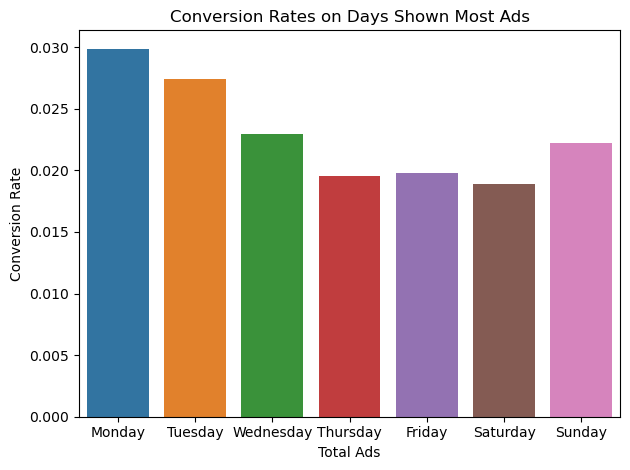

In [19]:
# Plot Days v Conversion Rate
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ax = sns.barplot(x=days, y=df_crate_days)
ax.set(title="Conversion Rates on Days Shown Most Ads", xlabel="Total Ads", ylabel="Conversion Rate")
plt.tight_layout()
plt.show()

In [20]:
max_day = df_crate_days.loc[df_crate_days == df_crate_days.max()]
max_day

most ads day
1    0.02987
Name: converted, dtype: float64

In [21]:
df_max_day = df.loc[df["most ads day"] == max_day.index[0]]
df_crate_max_day = df_max_day.groupby("test group")["converted"].mean()
max_day_lift = get_lift(df_crate_max_day["ad"], df_crate_max_day["psa"])
format(max_day_lift, ".1%")

'57.3%'

In [22]:
min_day = df_crate_days.loc[df_crate_days == df_crate_days.min()]
min_day

most ads day
6    0.018855
Name: converted, dtype: float64

In [23]:
df_min_day = df.loc[df["most ads day"] == min_day.index[0]]
df_crate_min_day = df_min_day.groupby("test group")["converted"].mean()
min_day_lift = get_lift(df_crate_min_day["ad"], df_crate_min_day["psa"])
format(min_day_lift, ".1%")

'57.0%'

In [24]:
# difference between day when most ads were shown and when fewest were
print(f"Max/Min day difference: {format(max_day_lift - min_day_lift, '.1%')}")

Max/Min day difference: 0.3%


#### Results
The difference in lift between being shown the most ads on a Monday and being shown the most ads on a Saturday is negligable. This indicates that the campaign is likely not affected by days of the week.

### Hours

In [25]:
df_crate_hours = df.groupby("most ads hour")["converted"].mean()
df_crate_hours

most ads hour
0     0.017207
1     0.012035
2     0.006664
3     0.010216
4     0.015737
5     0.016506
6     0.018878
7     0.015633
8     0.016852
9     0.017038
10    0.019262
11    0.019723
12    0.021579
13    0.022119
14    0.026022
15    0.026792
16    0.028982
17    0.026380
18    0.024642
19    0.023351
20    0.026827
21    0.025881
22    0.024287
23    0.021391
Name: converted, dtype: float64

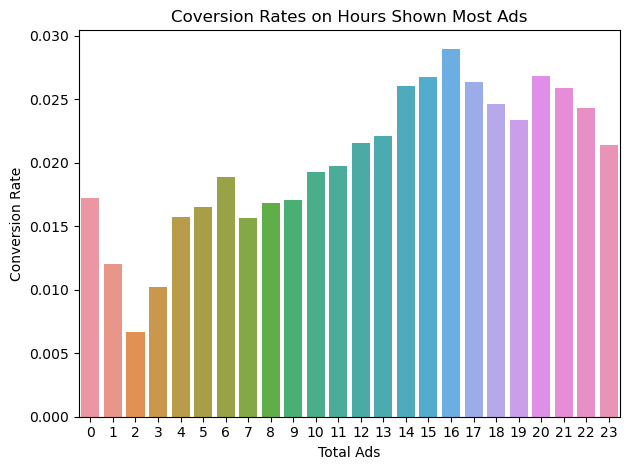

In [26]:
# Plot Hours v Conversion Rate

ax = sns.barplot(x=df_crate_hours.index, y=df_crate_hours)
ax.set(title="Coversion Rates on Hours Shown Most Ads", xlabel="Total Ads", ylabel="Conversion Rate")
plt.tight_layout()
plt.show()

In [27]:
# get max and min hr
max_hr = df_crate_hours.loc[df_crate_hours == df_crate_hours.max()].index[0]
print(f"Max hr: {max_hr}")

min_hr = df_crate_hours.loc[df_crate_hours == df_crate_hours.min()].index[0]
print(f"Min hr: {min_hr}")


Max hr: 16
Min hr: 2


In [28]:
%%capture --no-stdout 
# ^surpress divide by zero warning, as some hours do not have any control group conversions

# get Lift for each hour
hrs_lift = []


for hour in range(0,24):
    df_ = df.loc[df["most ads hour"] == hour]
    df_group_ = df_.groupby("test group")["converted"].mean()
    lift = get_lift(df_group_["ad"], df_group_["psa"])

    if (math.isfinite(lift)):
        hrs_lift.append(lift)
    else:
        hrs_lift.append(0)

print(hrs_lift)

[0, 0, 0, -0.13604378420641117, 0, 0, 0, 0.8449690272894692, 0.8667586262044698, 0.7115747369377972, 0.6659471274704492, 0.5515001909091717, 0.420171940267259, 0.5984527887866371, 1.0328572091081947, 0.3730743378573804, 0.12207747295500293, 0.4596204520730085, 0.1843222530265458, 0.08395441515765945, 0.921084749072447, 0.2562379485076971, 0.7195178913240585, 0.9072787677438838]


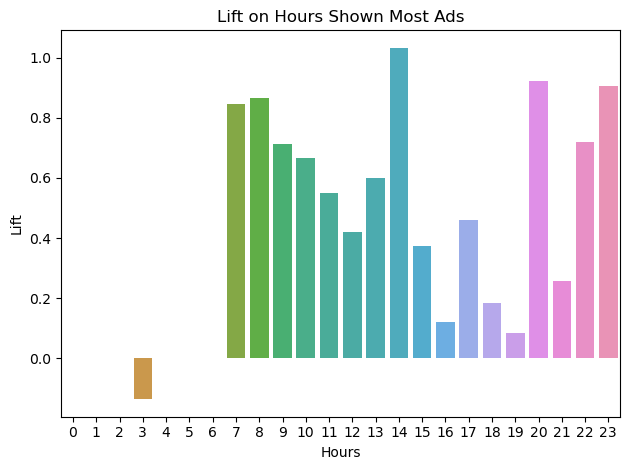

In [29]:
ax = sns.barplot(x=df_crate_hours.index, y=hrs_lift)
ax.set(title="Lift on Hours Shown Most Ads", xlabel="Hours", ylabel="Lift")
plt.tight_layout()
plt.show()

In [30]:
# Some hours, like the converstion rate min, had no control group conversions during their hour

print( "Number of records:",
    len(df.loc[(df["most ads hour"] == 2) & (df["converted"] == True)])
     )

print( "Unique test groups:",
    df.loc[(df["most ads hour"] == 2) & (df["converted"] == True)]["test group"].nunique()
     )

Number of records: 35
Unique test groups: 1


In [31]:
# Examine Hr 3, only negative lift
df.loc[(df["most ads hour"] == 3) & (df["converted"] == True)]

,user id,test group,converted,total ads,most ads day,most ads hour
11011,1229279,ad,True,129,1,3
13781,1246187,ad,True,100,2,3
14313,1112525,ad,True,130,2,3
38488,1187504,ad,True,73,4,3
46297,1453833,ad,True,128,7,3
46835,1367330,ad,True,26,2,3
47236,1401454,ad,True,56,2,3
58523,1026560,ad,True,47,4,3
62347,1073957,ad,True,10,5,3
67905,1266149,ad,True,134,2,3


In [32]:
# what percentage of the population during hr 3 were shown ads?
ad_count = len(df.loc[(df["most ads hour"] < 7) & (df["test group"] == "ad")])
psa_count = len(df.loc[(df["most ads hour"] < 7) & (df["test group"] == "psa")])

print( "# Ad group:", ad_count)
print( "# PSA group:", psa_count)
print( "% Control:", format(psa_count/ad_count, ".2%"))

# Ad group: 20677
# PSA group: 803
% Control: 3.88%


#### Results
There is a noticable difference between the conversion rates between the best (16h00, 4PM) and worst(02h00, 2AM) hours for conversions.

The worst hours for conversion also saw no conversions at all from the control group, with an exception of a single conversion during the 3rd hour. This could be further evidence that the ad campaign is effective, but the number of participants in the control group is a very small (803) at hour 3. The percentage is inline with the total population percentage of 4.16% having been assigned to the control group.

The best hours for lift were at 14, 20, and 23. These hours are non-contiguous and fell next to hours of relatively low conversion. Knowing more information about the company conducting the testing and the type of ads tested would likely provide insight into why spikes occur in lift during these hours.

One interesting trend is that between the hours of 14 and 20 we see some of the highest conversion rates among the general population, but see some of the lowest lift. This indicates that many visitors did during these hours are already intending to convert and running the campaign during these hours has relatively little effect. Lift during this period is still 24%, indicating that the ad campaign is likely still worth running.



In [33]:
# Get total lift for 14< hrs <20
df_ = df.loc[(df["most ads hour"] > 14) & (df["most ads hour"] < 20)]
df_group_ = df_.groupby("test group")["converted"].mean()
lift = get_lift(df_group_["ad"], df_group_["psa"])
format(lift, ".1%")

'23.7%'

### Total Ads Seen

In [34]:
df_crate_tot_ads = df.groupby(pd.cut(df["total ads"],
                                     [0,25, 50, 100, 175]))["converted"].mean()
df_crate_tot_ads

total ads
(0, 25]       0.005995
(25, 50]      0.035096
(50, 100]     0.113952
(100, 175]    0.176168
Name: converted, dtype: float64

In [35]:
df_crate_tot_ads = df.groupby(pd.cut(df["total ads"],
                                     range(0, 170, 20)))["converted"].mean()
df_crate_tot_ads

total ads
(0, 20]       0.004966
(20, 40]      0.023087
(40, 60]      0.065968
(60, 80]      0.117656
(80, 100]     0.154472
(100, 120]    0.174185
(120, 140]    0.183645
(140, 160]    0.167503
Name: converted, dtype: float64

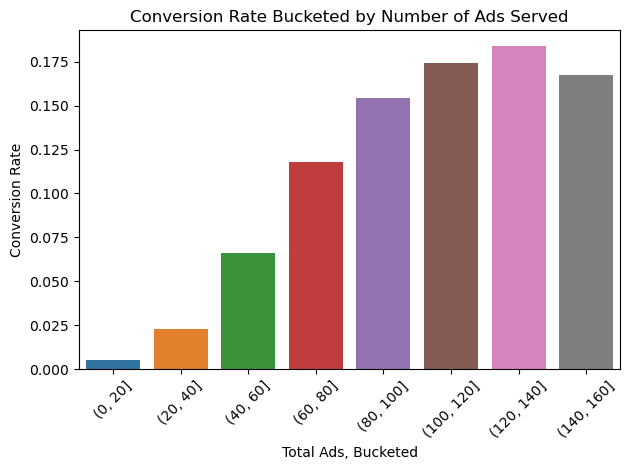

In [36]:
ax = sns.barplot(x=df_crate_tot_ads.index, y = df_crate_tot_ads)
ax.set(title="Conversion Rate Bucketed by Number of Ads Served", xlabel="Total Ads, Bucketed", ylabel="Conversion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
# get lift by 20
tot_bucket_lift = []

for r in df_crate_tot_ads.index:
    df_ = df.loc[(df["total ads"] >= r.left) & (df["total ads"] < r.right)]
    df_group_ = df_.groupby("test group")["converted"].mean()
    lift = get_lift(df_group_["ad"], df_group_["psa"])

    if (math.isfinite(lift)):
        tot_bucket_lift.append(lift)
    else:
        tot_bucket_lift.append(0)
tot_bucket_lift

[-0.02928991645106538,
 0.17189764098997284,
 0.7003780555913566,
 0.9768644442366701,
 1.3865775136206042,
 0.9587570283526734,
 0.775413371675054,
 0.26058611304512946]

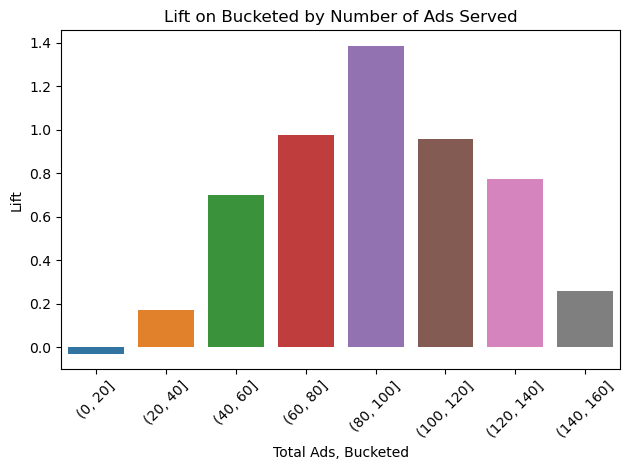

In [38]:
ax = sns.barplot(x=df_crate_tot_ads.index, y = tot_bucket_lift)
ax.set(title="Lift on Bucketed by Number of Ads Served", xlabel="Total Ads, Bucketed", ylabel="Lift")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
df_crate_tot_ads = df.groupby(pd.cut(df["total ads"], 
                                     range(0, 170, 10)))["converted"].mean()
df_crate_tot_ads

total ads
(0, 10]       0.003290
(10, 20]      0.008393
(20, 30]      0.017693
(30, 40]      0.032768
(40, 50]      0.055702
(50, 60]      0.081117
(60, 70]      0.110354
(70, 80]      0.127551
(80, 90]      0.146058
(90, 100]     0.165504
(100, 110]    0.169087
(110, 120]    0.180570
(120, 130]    0.184320
(130, 140]    0.182784
(140, 150]    0.162460
(150, 160]    0.179567
Name: converted, dtype: float64

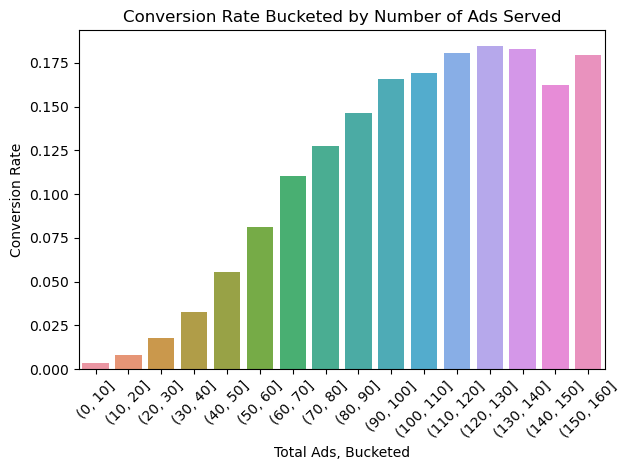

In [40]:
ax = sns.barplot(x=df_crate_tot_ads.index, y = df_crate_tot_ads)
ax.set(title="Conversion Rate Bucketed by Number of Ads Served", xlabel="Total Ads, Bucketed", ylabel="Conversion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
# get lift
tot_bucket_lift = []

for r in df_crate_tot_ads.index:
    df_ = df.loc[(df["total ads"] >= r.left) & (df["total ads"] < r.right)]
    df_group_ = df_.groupby("test group")["converted"].mean()
    lift = get_lift(df_group_["ad"], df_group_["psa"])

    if (math.isfinite(lift)):
        tot_bucket_lift.append(lift)
    else:
        tot_bucket_lift.append(0)
tot_bucket_lift

[-0.17898193020054087,
 0.010051602207469257,
 0.09928875449389984,
 0.1667349602118362,
 0.5484149446945388,
 0.8744512007081129,
 1.256305438673357,
 0.75951862226372,
 1.5714098575405275,
 1.2044768647643567,
 0.8947064906140629,
 1.0381724218933521,
 1.1612856937867697,
 0.4578378378378378,
 -0.022355931324238854,
 3.883720930232559]

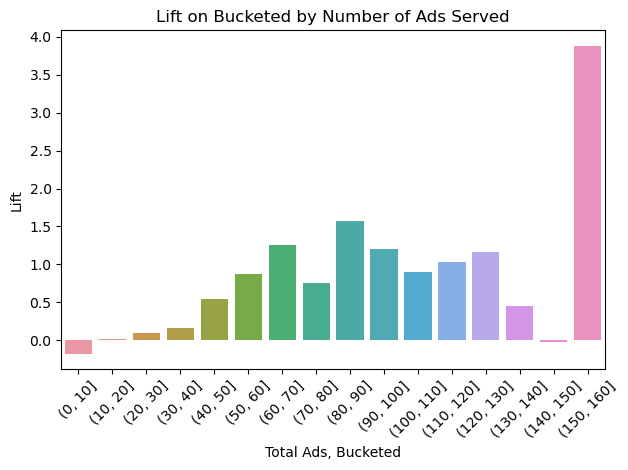

In [42]:
ax = sns.barplot(x=df_crate_tot_ads.index, y = tot_bucket_lift)
ax.set(title="Lift on Bucketed by Number of Ads Served", xlabel="Total Ads, Bucketed", ylabel="Lift")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
# Examine the >150 bucket
df_ = df.loc[df["total ads"] >= df_crate_tot_ads.index[-1].left]
df_.groupby("test group").count()


,user id,converted,total ads,most ads day,most ads hour
test group,,,,,
ad,774,774,774,774,774
psa,28,28,28,28,28


In [44]:
# get lift
l = []

for r in df_crate_tot_ads.index:
    df_ = df.loc[(df["total ads"] >= r.left) & (df["total ads"] < r.right)]
    l.append(len(df_))


print("Mean:",sum(l)/len(l))
l

Mean: 36129.375


[248910,
 130292,
 73170,
 40628,
 24007,
 16358,
 11460,
 8579,
 6365,
 4863,
 3743,
 2972,
 2425,
 1937,
 1559,
 802]

#### Results
Conversion rates increase with the number of ads shown. 
The is a predictable occurance based on a common-sense understanding of marketing.
It appears to drop off after about 140, however.

When bucked by every 20 ads shown, the lift follows an approximate normal curve.
While no bucket was negative, it appears that serving between 80 and 100 ads provides the greatest lift. 
Providing between 40 and 140 ads still provides an over 70% lift, so there is little chance of the campaign failing besed on serving total ads inside those boundaries.

Bucketing at every 10 ads serverd breaks the normal curve a bit. 
The >150 ads bucket shows a 400% lift, but only has 802 participants, compared to the average bucket size of 36k. It still shows a lift of over ~90% for total ads seen between 40 and 130 ads.

## Key Takeaways

- The ad campaign should proceed, with an expected total lift of ~50%
- Focus should be on ads in the early afternoon and night, specifically at hours 14, 20, and 23
- Users should be served between 40 and 140 total ads